## Тестовое задание

Во вложении представлен массив данных по вымышленным выданным POS-кредитам. 
Последний столбец отвечает за факт дефолта по займу. 
От вас требуется подготовить:

1) аналитическое исследование по представленному набору данных, отобразить информацию по качеству, структуре. При этом желательно отобразить интересные сегменты/зависимости в данных. 

2) рекомендации, математическую модель или любой инструмент, который позволит снизить дефолт. 

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, linear_model, svm, ensemble

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (17, 5)
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

**Загрузим данные и посмотрим на них внимательно:**

In [3]:
data = pd.read_csv('Data.txt', sep=';', encoding='cp1251')
data.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
0,1,7000,12,39,Мужской,Среднее специальное,Мобильные телефоны,Детей нет,Другие регионы,21000,Другое,МТС,Не клиент банка,Нет дефолта
1,1,19000,6,20,Мужской,Среднее специальное,Бытовая техника,Дети есть,Другие регионы,17000,Другое,Теле2,Клиент банка,Нет дефолта
2,1,29000,12,23,Женский,Среднее специальное,Бытовая техника,Детей нет,Другие регионы,31000,Другое,Билайн,Не клиент банка,Нет дефолта
3,1,10000,12,30,Мужской,Среднее специальное,Мобильные телефоны,Дети есть,Другие регионы,31000,Никогда не был(а) женат/замужем,Теле2,Клиент банка,Нет дефолта
4,1,14500,12,25,Женский,Высшее,Мобильные телефоны,Детей нет,Другие регионы,26000,Женат/замужем,МТС,Клиент банка,Нет дефолта


**Посмотрим на данные более внимательно. Итак, здесь пять количественных переменных, таких как сумма кредита (тип столбца int64), остальные - номинативные (категориальные) переменные, такие как пол клиента (тип столбца object):**

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
Месяц выдачи кредита          1723 non-null int64
Сумма кредита                 1723 non-null int64
Срок кредита                  1723 non-null int64
Возраст клиента               1723 non-null int64
Пол клиента                   1723 non-null object
Образование клиента           1723 non-null object
Тип товара                    1723 non-null object
Наличие детей у клиента       1723 non-null object
Регион выдачи кредита         1723 non-null object
Доход клиента                 1723 non-null int64
Семейное положение            1723 non-null object
Оператор связи                1723 non-null object
Является ли клиентом банка    1723 non-null object
Флаг дефолта по кредиту       1723 non-null object
dtypes: int64(5), object(9)
memory usage: 188.5+ KB


In [113]:
numeric_columns = ['Месяц выдачи кредита', 'Возраст клиента', 'Доход клиента', 'Сумма кредита', 'Срок кредита']

In [114]:
data.iloc[:, -1].value_counts(normalize=True)

Нет дефолта    0.886245
Дефолт         0.113755
Name: Флаг дефолта по кредиту, dtype: float64

In [115]:
data['Пол клиента'].value_counts(normalize=True)

Мужской    0.540337
Женский    0.459663
Name: Пол клиента, dtype: float64

In [116]:
data['Наличие детей у клиента'].value_counts(normalize=True)

Детей нет    0.571677
Дети есть    0.428323
Name: Наличие детей у клиента, dtype: float64

**Пропусков в данных нет. Классы несбалансированы: можно увидеть, что флаг "нет дефолта" примерно у 88% клиентов. При этом среди клиентов 54% мужчин и 46% женщин, дети есть у 57% клиентов. Посмотрим как распределены количественные признаки, записанные в переменную `numeric_columns`**

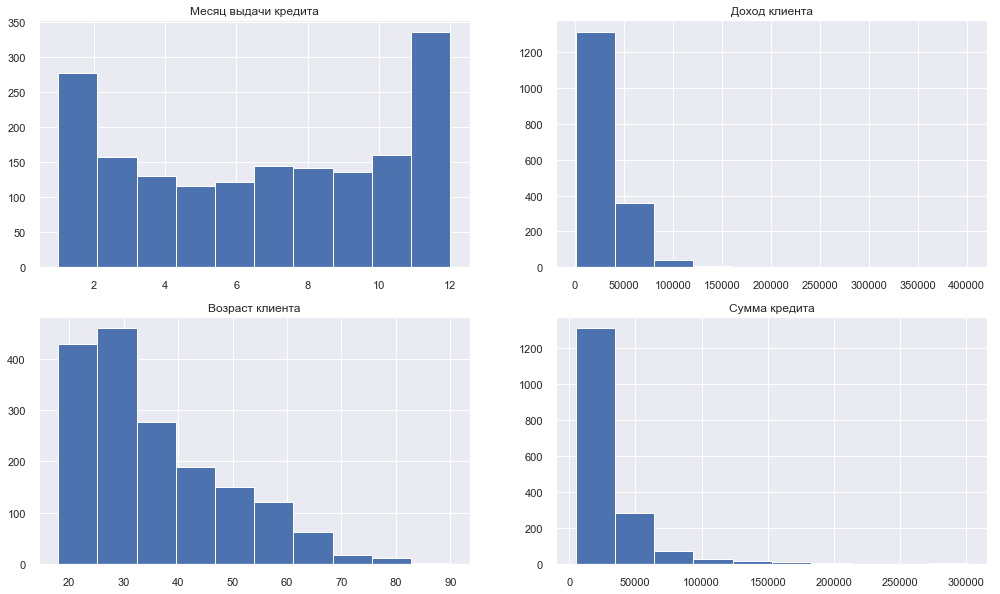

In [117]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(17, 10))
for i, ax in enumerate(axes):
    for j, a in zip(range(0,3,2), ax):
        a.hist(data[numeric_columns[i+j]])
        a.set_title(numeric_columns[i+j])

**Ни один из количественных признаков не распределен нормально. Видно, что большинство кредитов выдается в 1 и 12 месяце (январь и декабрь) и возраст большинства клиентов около 30 лет. Кроме этого большая часть клиентов имеет небольшой доход (до 50 тысяч) и берет небольшой кредит (до 40-50 тысяч), но при этом есть люди, у которых очень большой доход (до 400 тысяч) и которые берут в кредит большие суммы (до 300 тысяч).**

**Посмотрим как связан уровень образования клиента с его доходом, а также оценим как связан флаг дефолта с полом клиента и уровнем его дохода. Поскольку распределение дохода клиента асимметрично (имеет тяжелый правый хвост), то будем оценивать медиану дохода:**

In [120]:
data.groupby('Образование клиента')[['Доход клиента']].median().sort_values(by='Доход клиента', ascending=False)

,Доход клиента
Образование клиента,
Высшее,33000
Неоконченное высшее,31000
Несколько высших или более высокая ступень образования,31000
Среднее специальное,26000
Среднее,21500
Неоконченное среднее,21000


In [122]:
data.groupby(['Флаг дефолта по кредиту','Пол клиента'])[['Доход клиента']].median()

Доход клиента
Флаг дефолта по кредиту Пол клиента               
Дефолт                  Женский              30500
                        Мужской              23500
Нет дефолта             Женский              31000
                        Мужской              26000

**Видим, что в среднем доход выше у людей с высшим образованием, что достаточно ожидаемо. В то же время самый низкий доход у людей со средним и неоконченными средним образованием.**

**Стоит отметить, что у людей с флагом "Нет дефолта" средний доход выше по сравнению с категорией людей с флагом "Дефолт". При этом независимо от данного флага средний уровень дохода выше у женщин, а не у мужчин.**

**Построим матрицу корреляций количественных признаков:**

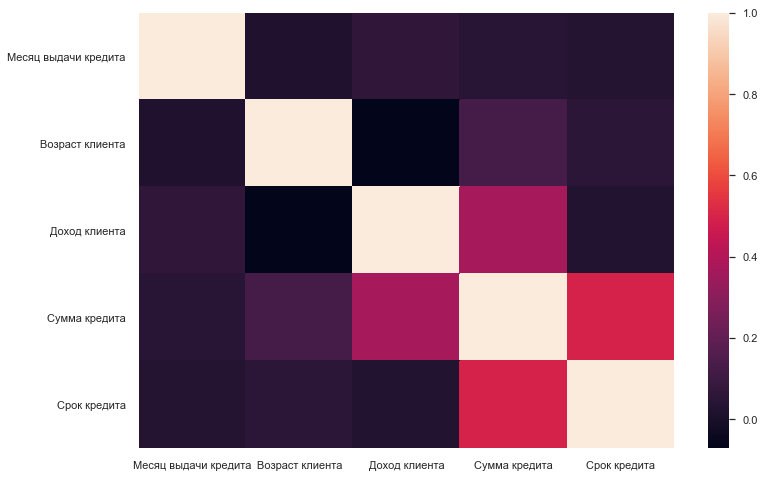

In [128]:
correlation_matrix = data[numeric_columns].corr() 
sns.heatmap(correlation_matrix)

**Видим, что признаки в основном некоррелированы, за исключением признаков "Сумма кредита" и "Срок кредита" с коэффициентом корреляции Пирсона около 0.5, что неудивительно - чем больше сумма тем, тем ожидаемо больше срок кредита.**

**Построим сводную таблицу `pivot_table`, чтобы оценить среднее значение количественных признаков, таких как возраст клиента, в двух группах - "Дефолт" и "Нет дефолта":**

In [130]:
data.pivot_table(['Сумма кредита', 'Срок кредита', 'Возраст клиента', 'Доход клиента'], 
                 ['Флаг дефолта по кредиту'], aggfunc='mean')

,Возраст клиента,Доход клиента,Срок кредита,Сумма кредита
Флаг дефолта по кредиту,,,,
Дефолт,32.173469,29367.346939,12.908163,28170.918367
Нет дефолта,36.391618,33074.001310,11.371971,29405.042567


**Видим, что с фактом дефолта связаны меньший средний возраст, меньший средний доход и большой срок кредита. В то же время в группе "Дефолт" несколько меньшая сумма кредита, что по-видимому связано со смещением среднего значения в группе "Нет дефолта" из-за больших сумм кредита. Построим ящики с усами для рассмотренных признаков, чтобы визуально оценить справедливость данных предположений:**

(0, 100000)

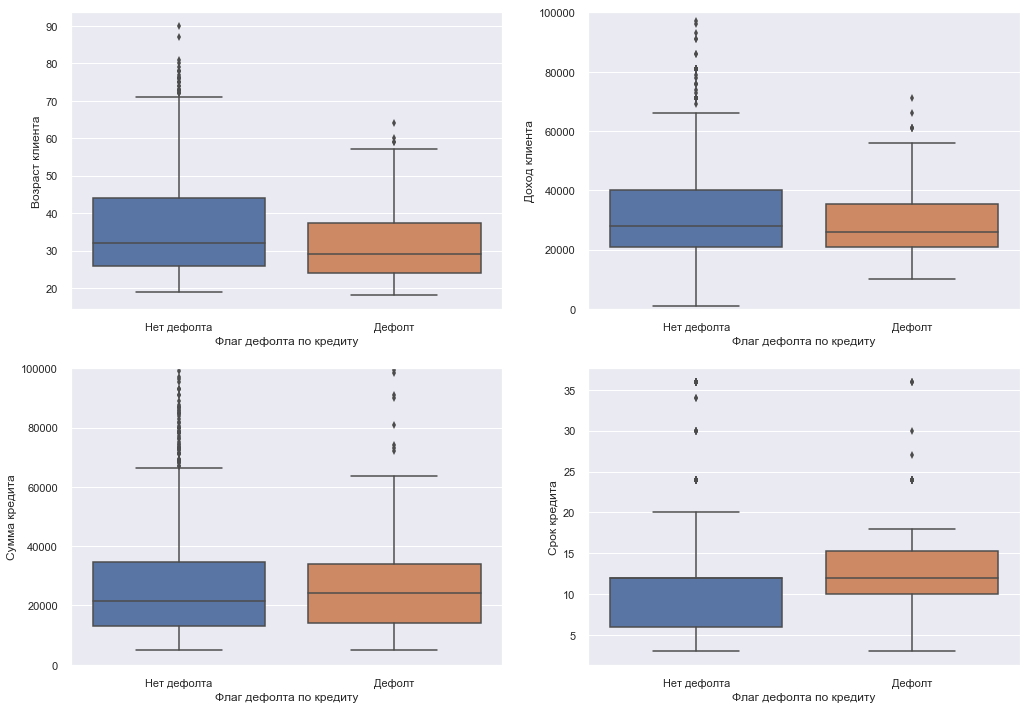

In [131]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17, 12))
sns.boxplot(x='Флаг дефолта по кредиту', y=numeric_columns[1], data=data, ax=axes[0][0])
sns.boxplot(x='Флаг дефолта по кредиту', y=numeric_columns[2], data=data, ax=axes[0][1])
axes[0][1].set_ylim([0, 100000])
sns.boxplot(x='Флаг дефолта по кредиту', y=numeric_columns[3], data=data, ax=axes[1][0])
sns.boxplot(x='Флаг дефолта по кредиту', y=numeric_columns[4], data=data, ax=axes[1][1])
axes[1][0].set_ylim([0, 100000])

**Видим, что медиана возраста и дохода выше в группе "Нет дефолта". Больший срок кредита в группе "Дефолт". Наконец, медиана суммы кредита выше в группе "Дефолт" - это согласуется с положительной корреляцией между сроком и суммой кредита.**

**Также оценим насколько статистически значимо различие признака в двух группах, взяв в качестве примера признак "Возраст" - в первой группе флаг "Дефолт" во второй группе - "Нет дефолта":**

In [9]:
sample_1 = data[data['Флаг дефолта по кредиту'] == 'Дефолт']['Возраст клиента']
sample_2 = data[data['Флаг дефолта по кредиту'] == 'Нет дефолта']['Возраст клиента']

In [18]:
from scipy import stats

# проверим распределение на нормальность
print('Проверка на нормальность - p_value: {}'.format(stats.normaltest(sample_1)[1]))
# проверим нулевую гипотезу о равенстве средних в двух группах
print('Критерий Манна-Уитни - p_value: {}'.format(stats.mannwhitneyu(sample_1, sample_2)[1]))

Проверка на нормальность - p_value: 6.853437137641772e-06
Критерий Манна-Уитни - p_value: 3.48789661993494e-05


**Для сравнения средних значений возраста в двух группах использован непараметрический критерий Манна-Уитни, поскольку распределение признака отличается от нормального. Достигаемый уровень значимости < 0.05 следовательно можно отклонить нулевую гипотезу в пользу альтернативной - мы получили статистически значимые различия - среднее значение возраста в группе "Дефолт" значимо отличается от среднего значения возраста в группе "Нет дефолта".**

**Далее будем строить таблицы сопряженности `crosstab` и визуально оценивать долю дефолта в группах:**

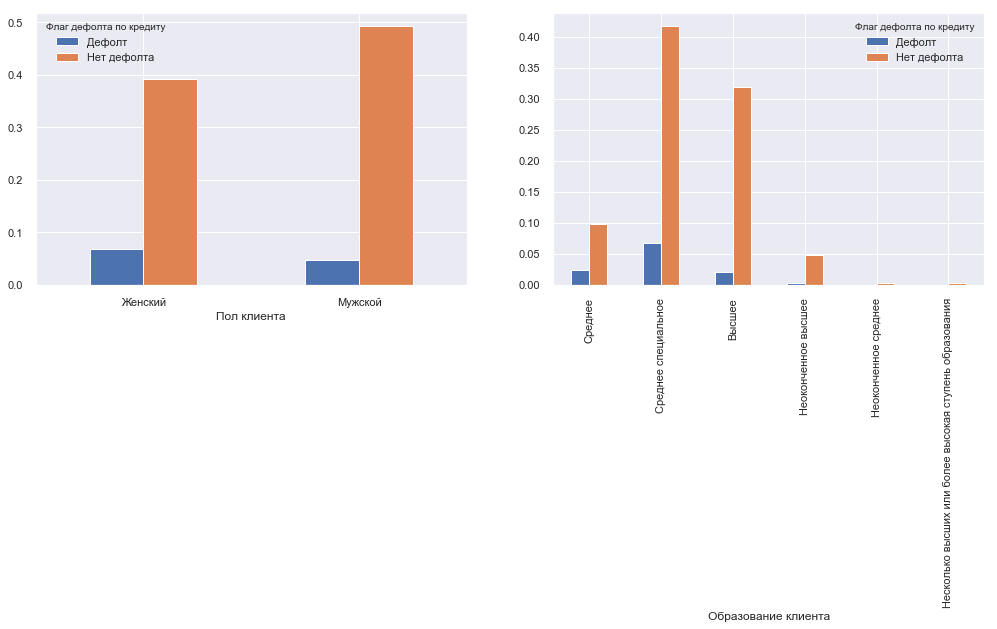

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

pd.crosstab(data['Пол клиента'], data['Флаг дефолта по кредиту'], normalize=True).plot(kind='bar', rot=0, 
                                                                                       figsize=(17, 5), 
                                                                                       ax=axes[0])

temp_table = pd.crosstab(data['Образование клиента'], data['Флаг дефолта по кредиту'], normalize=True)

temp_table['Соотношение'] = temp_table['Дефолт'] / temp_table['Нет дефолта']
temp_table.sort_values(by='Соотношение', ascending=False)[['Дефолт', 'Нет дефолта']].plot(kind='bar', rot=90, 
                                                                                          figsize=(17, 5),
                                                                                          ax=axes[1])

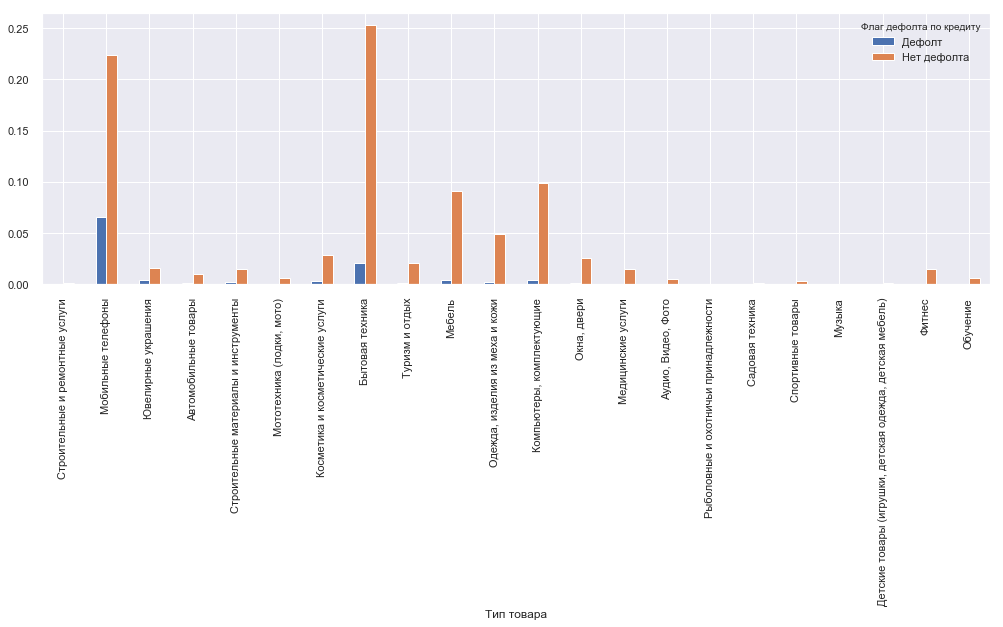

In [44]:
temp_table = pd.crosstab(data['Тип товара'], data['Флаг дефолта по кредиту'], normalize=True)
    
temp_table['Соотношение'] = temp_table['Дефолт'] / temp_table['Нет дефолта']
temp_table.sort_values(by='Соотношение', ascending=False)[['Дефолт', 'Нет дефолта']].plot(kind='bar', 
                                                                                          rot=90, figsize=(17, 5))

**Первое наблюдение - более высокая доля дефолта в группе женщин. Второе наблюдение связано с образованием - доля дефолта на этом рисунке упорядочена по убыванию: доля дефолта выше в группе со средним образованием (в этой же группе медиана дохода одна из самых маленьких), наименьшая доля дефолта в группе с несколькими высшими образованиями. Наконец, можно посмотреть на долю дефолта по типам товаров, упорядоченную по убыванию доли дефолта: видно, что доля дефолта высока для категории "Мобильные телефоны" и "Ювелирные украшения" (в категории "Строительные и ремонтные услуги" два кредита, один из которых с флагом дефолт, то есть доля дефолта 50%).**

**Далее закодируем все категориальные переменные аналогично LabelEncoder:**

In [21]:
# mapping = []

for i in range(data.shape[1]):

    if data.iloc[:, i].dtype == 'object':

        r = data.iloc[:, i].value_counts().shape[0]
        labels = data.iloc[:, i].value_counts().index

        d = {n: m for n, m in zip(labels, range(r))}
        
        # mapping.append(d)

        data.iloc[:, i].replace(d, inplace=True) 
        
        # можно было использовать pandas.factorize

In [22]:
data.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
0,1,7000,12,39,0,0,0,0,0,21000,0,1,1,0
1,1,19000,6,20,0,0,1,1,0,17000,0,3,0,0
2,1,29000,12,23,1,0,1,0,0,31000,0,2,1,0
3,1,10000,12,30,0,0,0,1,0,31000,2,3,0,0
4,1,14500,12,25,1,1,0,0,0,26000,1,1,0,0


In [24]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

**Наконец нормализуем некоторые количественные признаки, такие как сумма кредита:**

In [26]:
features = ['Сумма кредита', 'Возраст клиента', 'Доход клиента']

for f in features:
    X[f] = ( X[f] - X[f].mean() ) / X[f].std()
    
X.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка
0,1,-0.797251,12,0.235379,0,0,0,0,0,-0.557177,0,1,1
1,1,-0.367556,6,-1.212770,0,0,1,1,0,-0.748444,0,3,0
2,1,-0.009477,12,-0.984115,1,0,1,0,0,-0.079010,0,2,1
3,1,-0.689827,12,-0.450586,0,0,0,1,0,-0.079010,2,3,0
4,1,-0.528692,12,-0.831678,1,1,0,0,0,-0.318093,1,1,0


**Построим модель на полученной матрице объекты-признаки. Начнем с логистической регрессии. Метрикой качества будет ROC AUC. Качество модели будем оценить по кросс-валидации на 5 фолдов:**

In [88]:
skfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

model = linear_model.LogisticRegression(random_state=0, verbose=0)

param_grid = {'C': np.logspace(-3, 3, 7), 'class_weight': [None, 'balanced'], 
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}

clf = model_selection.GridSearchCV(model, param_grid, cv=skfold, scoring='roc_auc')

clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'class_weight': [None, 'balanced'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [90]:
# clf.best_estimator_
print('Итоговый AUC с LogisticRegression: {:.3f}'.format(clf.best_score_))

Итоговый AUC с LogisticRegression: 0.686


**Лучшая AUC в результате подбора параметров с GridSearchCV получилась равной 0.68 - это не очень хороший результат. Попробуем посмотреть почему получился такой результат с помощью T-SNE:**

In [144]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
tsne_embeddings = tsne.fit_transform(X)

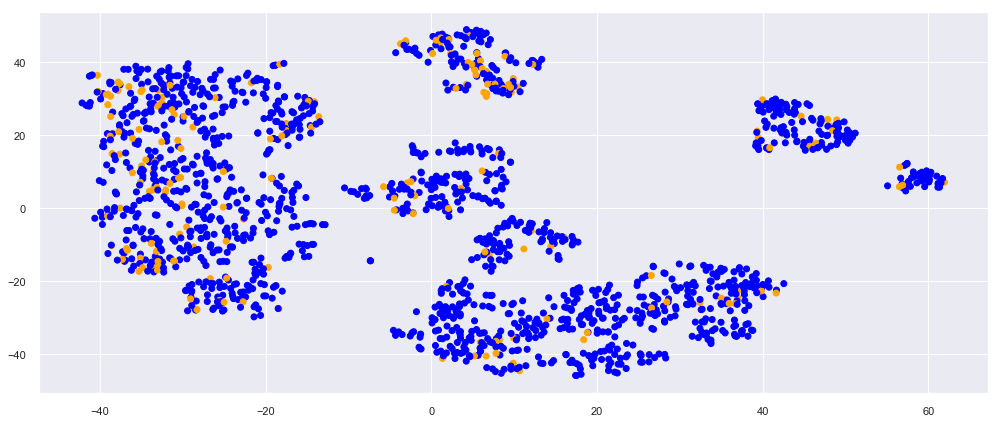

In [161]:
plt.figure(figsize=(17, 7))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c = y.map({0: 'blue', 1: 'orange'}) )

**Видим, что класс "Дефолт" (оранжевые круги) почти равномерно распределен по кластерам точек, никак не выделяясь - как результат плохая работа линейной модели. Похоже необходимы новые признаки. Но для начала попробуем использовать более сложную модель:**

In [92]:
model = svm.SVC(random_state=0, verbose=0, probability=True)

param_grid = {'kernel': ['rbf', 'sigmoid'], 'gamma': ['auto', 'scale'], 
              'class_weight': [None, 'balanced']}

clf = model_selection.GridSearchCV(model, param_grid, cv=skfold, scoring='roc_auc')

clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf', 'sigmoid'], 'gamma': ['auto', 'scale'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [93]:
# clf.best_estimator_
print('Итоговый AUC c SVC: {:.3f}'.format(clf.best_score_))

Итоговый AUC c SVC: 0.722


**SVM дает лучшее качество по сравнению с логистической регрессией. Посмотрим, что будет, если использовать случайный лес:**

In [94]:
model = ensemble.RandomForestClassifier(random_state=0, verbose=0)

param_grid = {'n_estimators': [20, 50, 150], 'criterion': ['gini', 'entropy'], 
              'max_depth': [None, 1, 10, 20], 'max_features': ['auto', None],
             'min_samples_leaf': [5, 10, 15], 'class_weight': ['balanced', None]}

clf = model_selection.GridSearchCV(model, param_grid, cv=skfold, scoring='roc_auc')

clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 50, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 10, 20], 'max_features': ['auto', None], 'min_samples_leaf': [5, 10, 15], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [95]:
# clf.best_estimator_
print('Итоговый AUC c RandomForest: {:.3f}'.format(clf.best_score_))

Итоговый AUC c RandomForest: 0.756


**Удалось повысить AUC до 0.75 - неплохой результат. Посмотрим топ-5 важных признаков:**

In [107]:
fi = clf.best_estimator_.feature_importances_
pd.DataFrame(zip(fi, data.columns[:-1]), 
             columns=['Важность', 'Признак']).sort_values(by='Важность', ascending=False).head()

,Важность,Признак
6,0.226390,Тип товара
1,0.159645,Сумма кредита
3,0.120192,Возраст клиента
2,0.112213,Срок кредита
9,0.093657,Доход клиента


**Видим, что наиболее важными признаками являются тип товара (ранее с помощью таблицы сопряженности показали, что доля дефолта значительно выше в категории "Мобильные телефоны"), сумма и срок кредита (с помощью ящиков с усами показали, что сумма и срок кредита в среднем выше для группы с флагом "Дефолт"), возраст клиента (с помощью ящика с усами показали, что возраст в среднем меньше для группы с флагом "Дефолт", при этом данное различие статистически значимо), а также доход клиента (с помощью ящика с усами показали, что доход в среднем меньше для группы с флагом "Дефолт").**

**Построим кривую обучения для того, чтобы оценить то, как метрика качества зависит от объема данных, на которых обучается модель:**

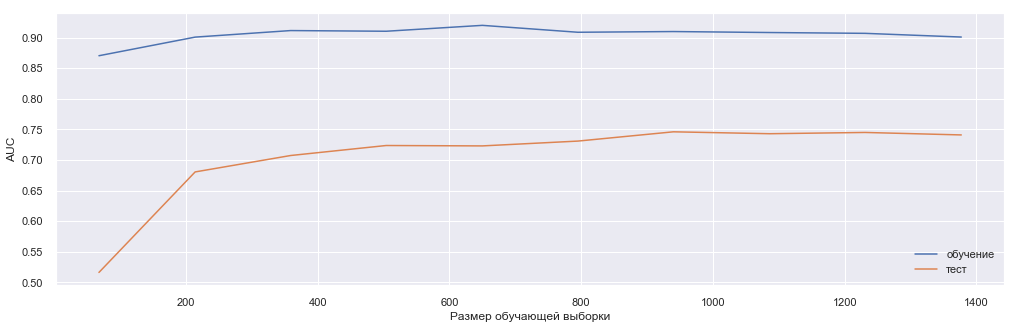

In [97]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.05, 1, 10)

n_train, val_train, val_test = learning_curve(clf.best_estimator_, X, y, train_sizes=train_sizes, cv=5, 
                                              scoring='roc_auc')

plt.figure(figsize=(17, 5))
plt.plot(n_train, val_train.mean(axis=1), label='обучение')
plt.plot(n_train, val_test.mean(axis=1), label='тест')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('AUC')
plt.legend()

**С увеличением количества данных кривые постепенно сходятся и это значит, что можно еще повысить качество на тесте, если добавить больше данных.**

**Попробуем придумать новые признаки:**

**(спойлер - это не поможет)**

In [98]:
data_mod = data.copy()
data_mod['f1'] = data_mod['Сумма кредита']**2
data_mod['f2'] = data_mod['Сумма кредита'] / data_mod['Срок кредита']
data_mod['f3'] = data_mod['Сумма кредита'] / data_mod['Возраст клиента']
data_mod['f4'] = data_mod['Сумма кредита'] / data_mod['Доход клиента']
data_mod['f5'] = data_mod['Доход клиента'] / data_mod['Возраст клиента']
data_mod['f6'] = data_mod['Доход клиента'] / data_mod['Срок кредита']
data_mod.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту,f1,f2,f3,f4,f5,f6
0,1,7000,12,39,0,0,0,0,0,21000,0,1,1,0,49000000,583.333333,179.487179,0.333333,538.461538,1750.000000
1,1,19000,6,20,0,0,1,1,0,17000,0,3,0,0,361000000,3166.666667,950.000000,1.117647,850.000000,2833.333333
2,1,29000,12,23,1,0,1,0,0,31000,0,2,1,0,841000000,2416.666667,1260.869565,0.935484,1347.826087,2583.333333
3,1,10000,12,30,0,0,0,1,0,31000,2,3,0,0,100000000,833.333333,333.333333,0.322581,1033.333333,2583.333333
4,1,14500,12,25,1,1,0,0,0,26000,1,1,0,0,210250000,1208.333333,580.000000,0.557692,1040.000000,2166.666667


In [99]:
X_ = data_mod.drop(['Флаг дефолта по кредиту'], axis=1)
y_ = data_mod.loc[:, 'Флаг дефолта по кредиту']

features = ['Сумма кредита', 'Возраст клиента', 'Доход клиента', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']

for f in features:
    X_[f] = ( X_[f] - X_[f].mean() ) / X_[f].std()

X_.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,f1,f2,f3,f4,f5,f6
0,1,-0.797251,12,0.235379,0,0,0,0,0,-0.557177,0,1,1,-0.322083,-0.814368,-0.851404,-0.353049,-0.674069,-0.438498
1,1,-0.367556,6,-1.212770,0,0,1,1,0,-0.748444,0,3,0,-0.258757,0.140309,0.088457,0.037430,-0.238313,-0.215532
2,1,-0.009477,12,-0.984115,1,0,1,0,0,-0.079010,0,2,1,-0.161333,-0.136855,0.467651,-0.053261,0.458007,-0.266986
3,1,-0.689827,12,-0.450586,0,0,0,1,0,-0.079010,2,3,0,-0.311731,-0.721980,-0.663745,-0.358402,0.018119,-0.266986
4,1,-0.528692,12,-0.831678,1,1,0,0,0,-0.318093,1,1,0,-0.289354,-0.583398,-0.362864,-0.241349,0.027444,-0.352742


In [100]:
model = ensemble.RandomForestClassifier(random_state=0, verbose=0)

param_grid = {'n_estimators': [20, 50, 150], 'criterion': ['gini', 'entropy'], 
              'max_depth': [None, 1, 10, 20], 'max_features': ['auto', None],
             'min_samples_leaf': [5, 10, 15], 'class_weight': ['balanced', None]}

clf_ = model_selection.GridSearchCV(model, param_grid, cv=skfold, scoring='roc_auc')

clf_.fit(X_, y_)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 50, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 10, 20], 'max_features': ['auto', None], 'min_samples_leaf': [5, 10, 15], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [101]:
#clf_.best_estimator_
print('Итоговый AUC c RandomForest на новых признаках: {:.3f}'.format(clf_.best_score_))

Итоговый AUC c RandomForest на новых признаках: 0.745


**Что интересно: если выкинуть маловажные признаки, такие как "Регион выдачи кредита" или "Семейное положение", то качество модели почти не ухудшится (останется на уровне 0.75)**

**Выполнено: февраль 2019**